In [1]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import casadi as ca

# 1. Parameterise a track

According to Mathias, an easy way to describe the motion of a car on a race track is to use the so called $\bf{curvilinear\ coordinate \ system}$. The first step to use curvilinear coordinate system is to find a parameterisation of the centre line of the track by its arc length.

Here, $\gamma_{c}(s)$ maps the arc length $s$ to the Cartesian coordinate of the track
$$
\gamma_{\text{c}}(s) = 
\begin{pmatrix}
x_{\text{r}}(s) \\
y_{\text{r}}(s)
\end{pmatrix}
$$

However, it is almost impossible to find an elegant mathematical representation of the centre line, and moreover, real-world censor only provides discrete data, for example, point clouds. One way to solve the problem is to use a set of ordered points to describe the centre line and interpolate between the points.


## 1.1 Problem formulation
 **Given:** A set of ordered points $(x_i, y_i)$, $i = 1, \dots, n$
 
 **Output:** A smooth curve that goes through every point. In particular, the curve needs to be:
  - $C^2$ smooth at each $(x_i, y_i)$

<center>
<img src="1.jpeg" width="50%">
</center>


## 1.2 Solution
Use the cubic spline to interpolate the ordered points.

A 3rd-order polynomial, which has 4 free parameters, can be used to interpolate between two points such that it satisfies 4 equations for each piece:

$$
\begin{cases}
\gamma_{i}(s_i) = \gamma_{i+1}(s_{i}) = (x_{i+1}, y_{i+1}) \\
\gamma_{i}(s_{i-1}) = \gamma_{i-1}(s_{i-1}) = (x_{i}, y_{i}) \\
\gamma_{i}'(s_i) = \gamma_{i+1}'(s_i) \\
\gamma_{i}''(s_i) = \gamma_{i+1}''(s_i)
\end{cases}
$$

Then

$$
\gamma(s)=
\begin{cases}
\gamma_1(s), & s_0 \leq s \leq s_1 \\
\gamma_2(s), & s_1 \leq s \leq s_2 \\
\vdots
\end{cases}
$$

is $C^2$ smooth.


## 1.3 Python implementation

In [2]:
## Input sample points of a track's center line
## point coordinate（x, y), unit: meter
x = np.array([
    0,  50, 100, 150, 200, 240, 270, 290, 300, 295, 280, 260, 230,
    200, 180, 160, 140, 120, 100,  80,  60,  40,  20,   0, -10, -20,
   -30, -30, -20,  -5,   0
])

y = np.array([
    0,   0,   0,   0,   10,  30,  60, 100, 140, 160, 180, 190, 195,
  190, 180, 160, 140, 120, 100,  80,  60,  40,  20,   0, -10, -30,
  -60, -80, -90, -95, -100
])

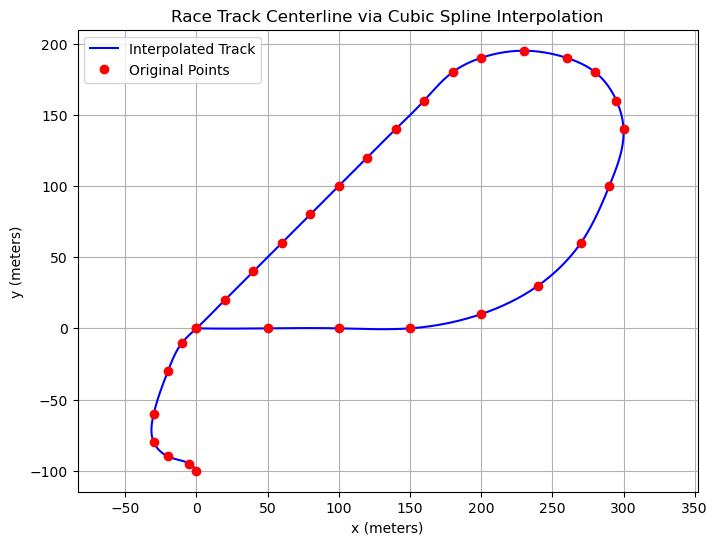

In [3]:
# Step 1: Compute arclengths
s = np.zeros(len(x))
s[1:] = np.cumsum(np.sqrt(np.diff(x)**2 + np.diff(y)**2))
s_max=s[-1] #the length of the track

# Step 2: Create cubic spline interpolators
x_spline = CubicSpline(s, x)
y_spline = CubicSpline(s, y)

# Step 3: Get the first and second derivative of the parameteriation
dx_ds = x_spline.derivative(1)
d2x_ds2 = x_spline.derivative(2)
dy_ds = y_spline.derivative(1)
d2y_ds2 = y_spline.derivative(2)

## Generate interpolated values for plotting
s_query = np.linspace(0, s_max, 500)
x_interp = x_spline(s_query)
y_interp = y_spline(s_query)

## Plot the spline
plt.figure(figsize=(8, 6))
plt.plot(x_interp, y_interp, label='Interpolated Track', color='blue')
plt.plot(x, y, 'ro', label='Original Points')
plt.axis('equal')
plt.title('Race Track Centerline via Cubic Spline Interpolation')
plt.xlabel('x (meters)')
plt.ylabel('y (meters)')
plt.legend()
plt.grid(True)
plt.show()

# output parameterisation and curvature as a casadi instance
x_ref = ca.interpolant('x_ref', 'linear', [s_query], x_interp)
y_ref = ca.interpolant('y_ref', 'linear', [s_query], y_interp)
kappa_ref_ = dx_ds(s_query)*d2y_ds2(s_query)-dy_ds(s_query)*d2x_ds2(s_query)
kappa_ref = ca.interpolant('kappa', 'linear', [s_query], kappa_ref_)

#### Plot the track with width

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/zhuwuzhe/anaconda3/lib/python3.11/site-packages/casadi/casadi.py", line 16873, in __array__
    return self.full()
           ^^^^^^^^^
  File "/Users/zhuwuzhe/anaconda3/lib/python3.11/site-packages/casadi/casadi.py", line 14330, in <lambda>
    __getattr__ = lambda self, name: _swig_getattr(self, MX, name)
                                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zhuwuzhe/anaconda3/lib/python3.11/site-packages/casadi/casadi.py", line 83, in _swig_getattr
    raise AttributeError("'%s' object has no attribute '%s'" % (class_type.__name__, name))
AttributeError: 'MX' object has no attribute 'full'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/zhuwuzhe/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/l_/gv8mx2r57n94pltqp7

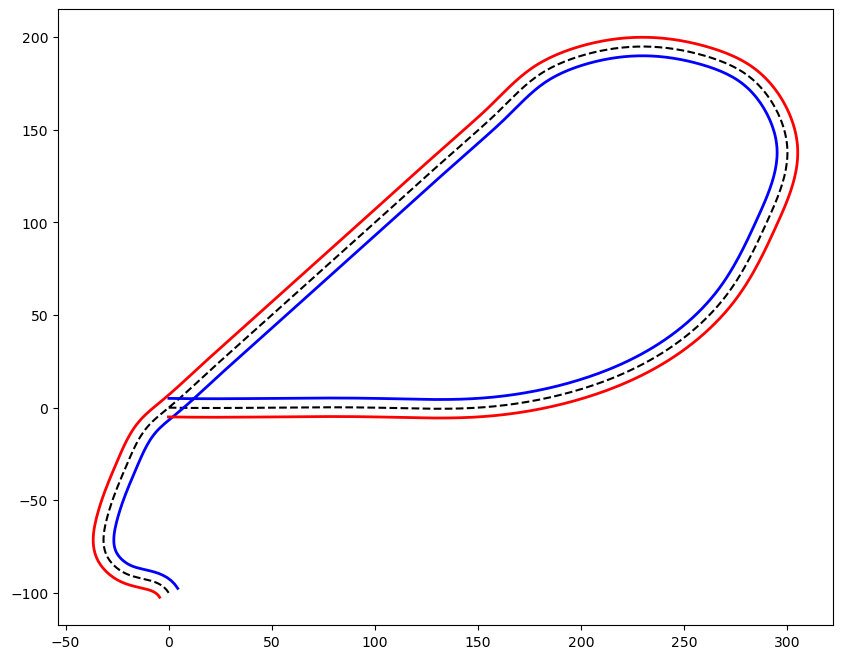

In [21]:
# s_query, x_interp, y_interp, dx_ds, dy_ds

# Track half-width
r = 5  # e.g., 5 meters width on each side

# Compute derivatives at query points
dx = dx_ds(s_query)
dy = dy_ds(s_query)

# Normalize tangent vectors to unit vectors
tangent_norm = np.sqrt(dx**2 + dy**2)
tangent_unit_x = dx / tangent_norm
tangent_unit_y = dy / tangent_norm

# Compute normal vectors (rotated tangent vectors by 90 degrees)
normal_x = -tangent_unit_y
normal_y = tangent_unit_x

# Compute left and right boundary points
x_left = x_interp + r * normal_x
y_left = y_interp + r * normal_y

x_right = x_interp - r * normal_x
y_right = y_interp - r * normal_y

# Plot the centerline and boundaries
plt.figure(figsize=(10, 8))
plt.plot(x_interp, y_interp, 'k--', linewidth=1.5, label='Center Line')
plt.plot(x_left, y_left, 'b-', linewidth=2, label='Left Boundary')
plt.plot(x_right, y_right, 'r-', linewidth=2, label='Right Boundary')

# Plot original points for reference
plt.plot(x, y, 'go', label='Original Points')

plt.axis('equal')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Track with Defined Width')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# 2. Reference path Optimization

According to Mathias, to simplify the problem, we can find an optimal path using MPC by setting the vehicle's velocity to be 1. The objective is then to maximize the vehicle's progress relative to the reference curve and to minimize the total curvature of the path. The curvature of the path is considered as a control variable and it is related to vehicle's tire model.

Inspired by Model Predictive Control (MPC), we first solve an optimization problem over a fixed prediction horizon. From the resulting solution, we apply only the control corresponding to the first time step. Then, we update the initial condition using the end state of the previous solution and repeat the process.

## 2.1 Problem formulation

Using $(s, r)$ to represent the vehicle's position, where $s$ is the projection on the centre line and $r$ is the lateral distance relative to it. Let $\kappa(t)$ be the curvature of the path at time $t$, $T$ be the predictive time scale, $t_i$ be the initial time, $\psi(t)$ be the path angle at time $t$, and $\psi_{\text{ref}}(t)$ be the centre line's angle at the vehicle's position at time $t$.

---

**Side notes – coordinate transform:**

$$
\kappa_{\text{ref}}(s) = \frac{x'_{\text{ref}}(s) y''_{\text{ref}}(s) - y'_{\text{ref}}(s) x''_{\text{ref}}(s)}{(x'_{\text{ref}}(s)^2 + y'_{\text{ref}}(s)^2)^{3/2}}
$$

$$
x(t) = x_{\text{ref}}(S(t)) - r(t) \cdot \sin(\psi_{\text{ref}}(S(t)))
$$

$$
y(t) = y_{\text{ref}}(S(t)) + r(t) \cdot \cos(\psi_{\text{ref}}(S(t)))
$$

---

According to Mathias, one possible formulation of this problem is the following:

### Objective

Minimize the objective function:

$$
-a_1 s(t_i + T) + a_2 \int_{t_i}^{t_i+T} \kappa(t)^2 \, dt
$$

### Subject to:

- **System dynamics:**


$$
\begin{cases}
\dot{s}(t) = \frac{\cos\big(\psi(t) - \psi_{\text{ref}}(t)\big)}{1 - r(t)\kappa_{\text{ref}}(s(t))}\\
\dot{r}(t) = \sin\big(\psi(t) - \psi_{\text{ref}}(t)\big)\\
\dot{\psi}(t) = \kappa(t)\\
\dot{\psi}_{\text{ref}}(t) = \kappa_{\text{ref}}(s(t)) \cdot \dot{s}(t)
\end{cases}
$$

- **Initial conditions:**

$$
\big(s(t_i),\, r(t_i),\, \psi(t_i),\, \psi_{\text{ref}}(t_i)\big) = \big(s_i,\, r_i,\, \psi_i,\, \psi_{\text{ref},i}\big)
$$

- **State constraints:**

$$
r(t) \in [r_{\min},\, r_{\max}]
$$

- **Control constraints:**

$$
\kappa(t) \in [\kappa_{\min},\, \kappa_{\max}]
$$


## 2.2 Problem discretization

For simplicity, $s(t_i)$ is written as $s_i$ and likewise. $h$ is the step size for discretizing time between $t_i$ and $t_i + T$. The number of discretization steps is $N - i + 1$. The trapezoidal rule is used for numerical integration, and the Euler method is used for the numerical solution of ODEs.


### **Objective:**

$$
-a_1 S_N + a_2 \sum_{n=1}^{N} \frac{h}{2} (\kappa_n + \kappa_{n-1})
$$


### **Subject to:**
- **System dynamics:**

For $j = i, \ldots, N-1$:

$$
\begin{cases}
S_{j+1} = S_j + h \cdot \dfrac{\cos(\psi_j - \psi_{\text{ref}, j})}{1 - r_j \kappa_{\text{ref}}(s_j)} \\
r_{j+1} = r_j + h \cdot \sin(\psi_j - \psi_{\text{ref}, j}) \\
\psi_{j+1} = \psi_j + h \kappa_j \\
\psi_{\text{ref}, j+1} = \psi_{\text{ref}, j} + h \cdot \kappa_{\text{ref}}(s_j) \cdot \dfrac{\cos(\psi_j - \psi_{\text{ref}, j})}{1 - r_j \kappa_{\text{ref}}(s_j)}
\end{cases}
$$


- **Initial Conditions:**

$$
(s_i, r_i, \psi_i, \psi_{\text{ref}, i})
$$


- **State Constraints:**

$$
r_j \in [r_{\min}, r_{\max}] \quad \text{for } j = i, \ldots, N
$$


- **Control Constraints:**

$$
\kappa_j \in [\kappa_{\min}, \kappa_{\max}] \quad \text{for } j = i, \ldots, N
$$


## 2.3 Solution

Use interior point method.

## 2.4 Python implementation

### Solving for one preditive step

In [27]:
# parameters determination
T = 800     # predictive time
N = 800     # time steps
nx = 4     # dimension of state
nu = 1     # dimension of control
h = T/N    # time step size

# define the state and control constraint
kappa_min=-1
kappa_max=1
r_min=-5
r_max=5

# define all variables, X: states, U: control
X = ca.MX.sym("X", N * nx)
U = ca.MX.sym("U", (N - 1) * nu)

# x_list[i] = (s_i,r_i,phi_i,phi_{ref,i})
# u_list[i] = (Kappa_i)
x_list = [X[i*nx:(i+1)*nx] for i in range(N)]
u_list = [U[i*nu:(i+1)*nu] for i in range(N - 1)]

# define objective funtion
a1 = 6.5e-4
a2 = 1

obj = -a1*x_list[N-1][0]+a2*(h*sum(u[0]**2 for u in u_list)-h*(u_list[0][0]**2+u_list[N-2][0]**2)/2)

# define constraint list
g_list = []

# equality constraint
for i in range(N - 1):
    xi = x_list[i]
    ui = u_list[i]
    x_dot = ca.vertcat(
        ca.cos(xi[2]-xi[3])/(1-xi[1]*kappa_ref(xi[0])),
        ca.sin(xi[2]-xi[3]),
        ui[0],
        kappa_ref(xi[0])*ca.cos(xi[2]-xi[3])/(1-xi[1]*kappa_ref(xi[0]))
    )
    xi_next_pred = xi + h * x_dot
    g_list.append(x_list[i + 1] - xi_next_pred)
    
# initial condition
g_list.append(x_list[0] - [0,0,0,0])

# inequality constraint
for u in u_list:
    g_list.append(u[0] - kappa_max)     # u <= u_max => u - u_max <= 0
    g_list.append(-u[0] + kappa_min)    # -u <= -u_min => -u + u_min <= 0
for x in x_list:
    g_list.append(x[1] - r_max)
    g_list.append(-x[1] + r_min)

# concat all constraints
g = ca.vertcat(*g_list)

# concat all variables
Z = ca.vertcat(X, U)

# define the NLP problem
nlp = {'x': Z, 'f': obj, 'g': g}

# define the solver
solver = ca.nlpsol('solver', 'ipopt', nlp)

# initial guess
z0 = np.zeros(Z.shape[0])

# upper & lower bounds for constraints
n_eq = 4*N -4 + 4     # dynamical equation + initial condition
n_ineq = 2 * (N - 1) +2*N # upper and lower bounds for inequality constraint

lbg = [0] * n_eq + [-ca.inf] * n_ineq
ubg = [0] * n_eq + [0] * n_ineq

# solving
sol = solver(x0=z0, lbg=lbg, ubg=ubg)
z_opt = sol['x'].full().flatten()

# unpack variables
x_opt = z_opt[:nx*N].reshape((N, nx))
u_opt = z_opt[nx*N:].reshape((N - 1, nu))

print("if success:", solver.stats()['success'])
print("the first 5 states:", x_opt[:5])
print("the first 5 control:", u_opt[:5])

# Extract variables
s_vals = x_opt[:, 0]  # x[0], s
r_vals = x_opt[:, 1]  # x[1], r
phi_vals = x_opt[:,2] # x[2], phi
phi_ref_vals = x_opt[:,3] # x[3], phi_ref

# coordinate transform
x_vals=x_ref(s_vals).full().flatten()-r_vals*np.sin(phi_ref_vals)
y_vals=y_ref(s_vals).full().flatten()+r_vals*np.cos(phi_ref_vals)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13587
Number of nonzeros in inequality constraint Jacobian.:     3198
Number of nonzeros in Lagrangian Hessian.............:     8789

Total number of variables............................:     3999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3200
Total number of inequality constraints...............:     3198
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:     3198

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 2.67e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

### Plot the track and resulting reference path

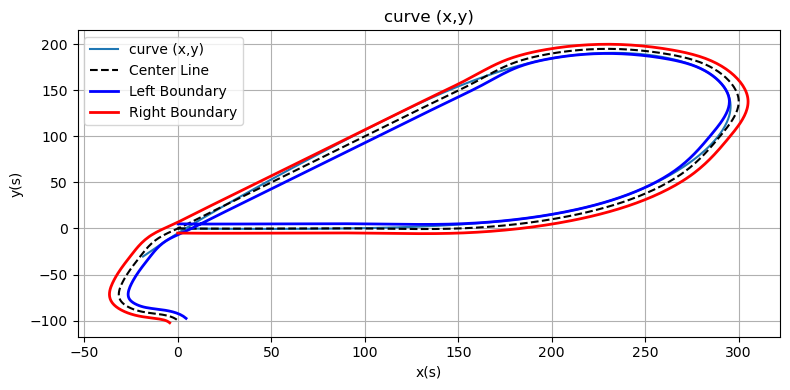

In [28]:
plt.figure(figsize=(8, 4))
plt.plot(x_vals, y_vals, label='curve (x,y)')
plt.plot(x_interp, y_interp, 'k--', linewidth=1.5, label='Center Line')
plt.plot(x_left, y_left, 'b-', linewidth=2, label='Left Boundary')
plt.plot(x_right, y_right, 'r-', linewidth=2, label='Right Boundary')
plt.xlabel('x(s)')
plt.ylabel('y(s)')
plt.title('curve (x,y)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Solving for the whole MPC problem

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.00e-01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.50e+00 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.00e+00 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.50e+00 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 6.00e+00 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.50e+00 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.00e+00 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.05e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.20e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.35e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.50e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.65e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.80e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.95e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.10e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.25e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.35e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.45e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.55e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.65e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.75e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.85e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.95e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.05e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.15e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.30e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.45e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.60e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.75e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.90e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.05e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.20e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.35e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.50e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.65e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.80e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.90e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.00e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.10e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.20e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.30e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.40e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.50e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.60e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.70e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.80e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.90e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 6.00e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 6.10e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 6.20e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 6.30e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 6.40e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 6.50e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 6.60e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 6.70e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 6.80e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 6.90e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.00e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.10e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.20e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.30e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.40e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.50e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.60e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.70e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.80e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.95e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 8.10e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 8.20e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 8.30e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 8.40e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 8.50e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 8.60e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 8.70e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 8.80e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 8.90e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.00e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.09e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.19e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.29e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.39e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.49e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.59e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.69e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.79e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.89e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.99e+01 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.01e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.02e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.03e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.04e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.05e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.06e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.07e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.08e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.09e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.10e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.11e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.12e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.13e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.14e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.15e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.16e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.17e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.18e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.19e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.20e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.21e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.22e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.23e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.24e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.25e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.26e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.27e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.28e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.29e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.30e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.31e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.32e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.33e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.34e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.35e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.36e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.37e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.38e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.39e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.40e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.41e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.42e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.43e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.44e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.45e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.46e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.47e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.48e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.49e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.50e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.51e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.52e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.53e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.54e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.55e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.56e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.57e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.58e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.59e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.60e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.61e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.62e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.63e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.65e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.66e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.67e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.68e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.69e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.70e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.71e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.72e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.73e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.74e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.75e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.76e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.77e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  38 -1.7938226e-01 4.54e-08 2.51e-14  -8.6 7.88e-14    -  1.00e+00 1.00e+00h  1
  39 -1.7938226e-01 4.54e-08 2.51e-14  -8.6 2.60e-13    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 -1.7938226e-01 4.54e-08 2.51e-14  -8.6 2.45e-13    -  1.00e+00 1.00e+00h  1
  41 -1.7938226e-01 4.54e-08 2.51e-14  -8.6 2.64e-13    -  1.00e+00 1.00e+00h  1
  42 -1.7938226e-01 4.54e-08 2.51e-14  -8.6 7.21e-14    -  1.00e+00 1.00e+00h  1
  43 -1.7938226e-01 4.54e-08 2.51e-14  -8.6 1.04e-13    -  1.00e+00 1.00e+00h  1
  44 -1.7938226e-01 4.54e-08 3.64e-12  -8.6 1.86e-13    -  1.00e+00 1.00e+00h  1
  45 -1.7938226e-01 4.54e-08 2.51e-14  -8.6 4.53e-14    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 45

                                   (scaled)                 (unscaled)
Objective...............:  -1.7938226388847328e-01   -1.7938226388847328e-01
Dual infeasibility......:   2.5059815333960955e-14    2.5059815333960955e-14
Constraint viol

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.79e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.80e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.81e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.82e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.83e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.84e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.85e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.86e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.87e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.88e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.89e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.90e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.91e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.92e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.93e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.94e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.95e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.96e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.97e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.98e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.99e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.00e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.01e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.02e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.04e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.05e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.06e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.07e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.08e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.09e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.10e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.11e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.12e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.13e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.14e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  35 -2.0254778e-01 3.83e-08 3.64e-12  -8.6 1.84e-10    -  1.00e+00 1.00e+00h  1
  36 -2.0254778e-01 3.83e-08 3.68e-14  -8.6 5.31e-10    -  1.00e+00 1.00e+00h  1
  37 -2.0254778e-01 3.83e-08 2.51e-14  -8.6 3.62e-13    -  1.00e+00 1.00e+00h  1
  38 -2.0254778e-01 3.83e-08 2.51e-14  -8.6 6.89e-14    -  1.00e+00 1.00e+00h  1
  39 -2.0254778e-01 3.83e-08 2.51e-14  -8.6 2.24e-13    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 -2.0254778e-01 3.83e-08 3.64e-12  -8.6 2.17e-13    -  1.00e+00 1.00e+00h  1
  41 -2.0254778e-01 3.83e-08 2.51e-14  -8.6 1.34e-14    -  1.00e+00 1.00e+00h  1
  42 -2.0254778e-01 3.83e-08 2.51e-14  -8.6 2.16e-13    -  1.00e+00 1.00e+00h  1
  43 -2.0254778e-01 3.83e-08 3.64e-12  -8.6 2.10e-13    -  1.00e+00 1.00e+00h  1
  44 -2.0254778e-01 3.83e-08 3.64e-12  -8.6 5.18e-14    -  1.00e+00 1.00e+00h  1
  45 -2.0254778e-01 3.83e-08 2.51e-14  -8.6 2.21e-13    -  1.00e+00 1.00e+00h  1
  46 -2.0254778e-01 3.83e-08

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.16e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.17e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.18e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  35 -2.0517507e-01 3.28e-08 5.29e-14  -8.6 7.51e-08    -  1.00e+00 1.00e+00h  1
  36 -2.0517507e-01 3.46e-08 7.28e-12  -8.6 3.52e-08    -  1.00e+00 1.00e+00h  1
  37 -2.0517507e-01 3.46e-08 7.28e-12  -8.6 8.43e-13    -  1.00e+00 1.00e+00h  1
  38 -2.0517507e-01 3.46e-08 2.51e-14  -8.6 1.48e-13    -  1.00e+00 1.00e+00h  1
  39 -2.0517507e-01 3.46e-08 2.51e-14  -8.6 1.98e-13    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 -2.0517507e-01 3.46e-08 2.51e-14  -8.6 1.27e-14    -  1.00e+00 1.00e+00h  1
  41 -2.0517507e-01 3.46e-08 7.28e-12  -8.6 1.91e-13    -  1.00e+00 1.00e+00h  1
  42 -2.0517507e-01 3.46e-08 3.03e-14  -8.6 5.11e-14    -  1.00e+00 1.00e+00h  1
  43 -2.0517507e-01 3.46e-08 2.51e-14  -8.6 3.38e-14    -  1.00e+00 1.00e+00h  1
  44 -2.0517507e-01 3.46e-08 3.64e-12  -8.6 2.27e-13    -  1.00e+00 1.00e+00h  1
  45 -2.0517507e-01 3.46e-08 3.64e-12  -8.6 4.38e-14    -  1.00e+00 1.00e+00h  1
  46 -2.0517507e-01 3.46e-08

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.20e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.21e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.22e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.23e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.24e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.25e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.26e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.27e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.28e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.29e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.30e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.31e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.32e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.33e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.34e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.36e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.37e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.38e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.39e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.40e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.41e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.42e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.43e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.44e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.45e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.46e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.47e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.48e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.49e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.50e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.51e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.52e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.53e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.54e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.55e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.56e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.57e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.58e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.59e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.60e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.62e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.64e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.65e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.66e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.67e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.68e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.69e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.70e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.71e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.72e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.73e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.74e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.75e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.76e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.77e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.78e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  37 -2.4523215e-01 4.13e-08 1.46e-11  -8.6 3.90e-13    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 37

                                   (scaled)                 (unscaled)
Objective...............:  -2.4523215092495990e-01   -2.4523215092495990e-01
Dual infeasibility......:   1.4551915228366852e-11    1.4551915228366852e-11
Constraint violation....:   4.1349274226831767e-08    4.1349274226831767e-08
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   4.1349274226831767e-08    4.1349274226831767e-08


Number of objective function evaluations             = 38
Number of objective gradient evaluations             = 38
Number of equality constraint evaluations            = 38
Number of inequality constraint evaluations          = 38
Number of equality constraint Jacobian evaluations   = 38
Number of inequality constraint Jacobian evaluations = 38
Numbe

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.80e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.81e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.82e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  37 -2.4757885e-01 5.22e-08 7.28e-12  -8.6 4.56e-12    -  1.00e+00 1.00e+00h  1
  38 -2.4757885e-01 5.22e-08 1.14e-13  -8.6 8.32e-12    -  1.00e+00 1.00e+00h  1
  39 -2.4757885e-01 5.22e-08 2.27e-13  -8.6 2.01e-11    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 39

                                   (scaled)                 (unscaled)
Objective...............:  -2.4757884985203749e-01   -2.4757884985203749e-01
Dual infeasibility......:   2.2737367544323206e-13    2.2737367544323206e-13
Constraint violation....:   5.2206560852141592e-08    5.2206560852141592e-08
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   5.2206560852141592e-08    5.2206560852141592e-08


Number of objective function evaluations             = 41
Number of objective gradient evaluations             = 40
Number of equality constraint evaluations            = 41
Number of inequal

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.83e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.85e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.86e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.87e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.88e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.89e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.90e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.91e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.92e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.93e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.94e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.95e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.96e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.97e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.98e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.99e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.00e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.01e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.02e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.03e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.04e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.05e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.06e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.07e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.08e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.09e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.10e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.11e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.12e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.14e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.15e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.16e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.17e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.18e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.19e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.20e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.21e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.22e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.23e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.24e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.25e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.26e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.27e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.28e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.29e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.30e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.31e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.32e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.33e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.34e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.35e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.36e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.37e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.38e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.39e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.40e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.41e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.42e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.43e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.44e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.45e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.46e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.47e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.48e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.49e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.50e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.51e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.52e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.53e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.54e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.55e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.56e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.57e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.58e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.60e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.61e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.62e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.63e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.64e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.65e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.66e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.67e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.68e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.69e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.70e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.72e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.73e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.74e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.75e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.76e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.77e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.78e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.79e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.80e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.82e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.83e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.84e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.85e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.86e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.87e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.88e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.89e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.90e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.91e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.93e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.94e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.95e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  43 -3.0724923e-01 5.56e-05 1.26e+00  -5.7 2.41e-01    -  1.00e+00 7.84e-01h  1
  44 -3.0728369e-01 1.91e-05 6.20e-06  -5.7 6.75e-02    -  1.00e+00 1.00e+00f  1
  45 -3.0728477e-01 1.46e-08 7.10e-10  -5.7 5.44e-03    -  1.00e+00 1.00e+00h  1
  46 -3.0735010e-01 8.02e-06 8.37e+01  -8.6 2.42e-01    -  9.69e-01 7.46e-01h  1
  47 -3.0735944e-01 4.30e-06 4.43e+01  -8.6 9.10e-02    -  1.00e+00 5.35e-01h  1
  48 -3.0736242e-01 6.53e-07 5.85e-09  -8.6 4.01e-02    -  1.00e+00 1.00e+00h  1
  49 -3.0736279e-01 1.04e-07 2.46e-04  -8.6 1.15e-03    -  1.00e+00 8.41e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 -3.0736285e-01 5.86e-08 5.00e-04  -8.6 6.12e-04    -  1.00e+00 4.36e-01f  1
  51 -3.0736291e-01 3.80e-09 1.05e-10  -8.6 4.43e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 51

                                   (scaled)                 (unscaled)
Objective...............:  -3.0736290790174836e-01   -3.0736290790174836e-01
Dual infeas

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.97e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.98e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.99e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.01e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.02e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.03e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.05e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.06e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.07e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.08e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.09e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.10e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.11e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.12e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.13e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.15e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.16e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.17e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.18e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.19e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.20e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.21e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.22e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.24e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.25e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.26e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.27e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.28e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.29e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.30e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.31e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.32e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.33e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.34e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.36e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.37e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.38e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  37 -3.4446233e-01 4.72e-08 7.28e-12  -8.6 1.09e-12    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 37

                                   (scaled)                 (unscaled)
Objective...............:  -3.4446232881683736e-01   -3.4446232881683736e-01
Dual infeasibility......:   7.2759576141834259e-12    7.2759576141834259e-12
Constraint violation....:   4.7209057107977515e-08    4.7209057107977515e-08
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800626e-09    2.5059035596800626e-09
Overall NLP error.......:   4.7209057107977515e-08    4.7209057107977515e-08


Number of objective function evaluations             = 38
Number of objective gradient evaluations             = 38
Number of equality constraint evaluations            = 38
Number of inequality constraint evaluations          = 38
Number of equality constraint Jacobian evaluations   = 38
Number of inequality constraint Jacobian evaluations = 38
Numbe

  38 -3.4515135e-01 4.58e-08 2.27e-13  -8.6 7.75e-13    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 38

                                   (scaled)                 (unscaled)
Objective...............:  -3.4515134828549737e-01   -3.4515134828549737e-01
Dual infeasibility......:   2.2737367544323206e-13    2.2737367544323206e-13
Constraint violation....:   4.5777808210800686e-08    4.5777808210800686e-08
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800626e-09    2.5059035596800626e-09
Overall NLP error.......:   4.5777808210800686e-08    4.5777808210800686e-08


Number of objective function evaluations             = 39
Number of objective gradient evaluations             = 39
Number of equality constraint evaluations            = 39
Number of inequality constraint evaluations          = 39
Number of equality constraint Jacobian evaluations   = 39
Number of inequality constraint Jacobian evaluations = 39
Numbe

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.41e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.42e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.43e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.44e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  38 -3.4847961e-01 3.82e-08 2.51e-14  -8.6 4.27e-14    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 38

                                   (scaled)                 (unscaled)
Objective...............:  -3.4847961417999757e-01   -3.4847961417999757e-01
Dual infeasibility......:   2.5059042839913059e-14    2.5059042839913059e-14
Constraint violation....:   3.8155623549585016e-08    3.8155623549585016e-08
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   3.8155623549585016e-08    3.8155623549585016e-08


Number of objective function evaluations             = 39
Number of objective gradient evaluations             = 39
Number of equality constraint evaluations            = 39
Number of inequality constraint evaluations          = 39
Number of equality constraint Jacobian evaluations   = 39
Number of inequality constraint Jacobian evaluations = 39
Numbe

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.46e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  3.0313786e-01 1.80e+02 5.36e-01  -1.0 5.45e+02    -  3.86e-01 5.95e-01h  1
   2  7.1619885e-01 1.80e+00 2.14e-01  -1.0 2.19e+02    -  7.93e-01 9.90e-01h  1
   3  3.4579934e-01 1.80e-02 1.54e-01  -1.0 2.57e+00    -  9.61e-01 9.90e-01h  1
   4 -1.8535514e-0

  36 -3.4948592e-01 3.76e-08 2.51e-14  -8.6 4.26e-14    -  1.00e+00 1.00e+00h  1
  37 -3.4948592e-01 3.76e-08 9.09e-13  -8.6 4.06e-14    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 37

                                   (scaled)                 (unscaled)
Objective...............:  -3.4948592308071891e-01   -3.4948592308071891e-01
Dual infeasibility......:   9.0949470177292824e-13    9.0949470177292824e-13
Constraint violation....:   3.7633602012476786e-08    3.7633602012476786e-08
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   3.7633602012476786e-08    3.7633602012476786e-08


Number of objective function evaluations             = 38
Number of objective gradient evaluations             = 38
Number of equality constraint evaluations            = 38
Number of inequality constraint evaluations          = 38
Number of equality constraint Jacobian e

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.47e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  3.0252547e-01 1.81e+02 5.36e-01  -1.0 5.47e+02    -  3.86e-01 5.95e-01h  1
   2  7.1747724e-01 1.81e+00 2.14e-01  -1.0 2.19e+02    -  7.93e-01 9.90e-01h  1
   3  3.4470529e-01 1.81e-02 1.54e-01  -1.0 2.64e+00    -  9.61e-01 9.90e-01h  1
   4 -1.9542065e-0

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.48e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.49e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.50e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.51e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.52e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.53e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.55e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.56e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.57e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.58e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.59e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.60e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.61e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.62e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.63e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.64e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.65e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  33 -3.6280848e-01 3.20e-08 2.51e-14  -8.6 1.54e-14    -  1.00e+00 1.00e+00h  1
  34 -3.6280848e-01 3.20e-08 2.51e-14  -8.6 8.71e-15    -  1.00e+00 1.00e+00h  1
  35 -3.6280848e-01 3.20e-08 1.82e-12  -8.6 1.67e-14    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 35

                                   (scaled)                 (unscaled)
Objective...............:  -3.6280847737053828e-01   -3.6280847737053828e-01
Dual infeasibility......:   1.8189894035458565e-12    1.8189894035458565e-12
Constraint violation....:   3.1975941006123776e-08    3.1975941006123776e-08
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800626e-09    2.5059035596800626e-09
Overall NLP error.......:   3.1975941006123776e-08    3.1975941006123776e-08


Number of objective function evaluations             = 36
Number of objective gradient evaluations             = 36
Number of equality constraint evaluations            = 36
Number of inequal

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.67e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  33 -3.6394698e-01 3.14e-08 2.51e-14  -8.6 1.69e-13    -  1.00e+00 1.00e+00h  1
  34 -3.6394698e-01 3.14e-08 1.46e-11  -8.6 1.16e-13    -  1.00e+00 1.00e+00h  1
  35 -3.6394698e-01 3.14e-08 1.82e-12  -8.6 1.25e-14    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 35

                                   (scaled)                 (unscaled)
Objective...............:  -3.6394697524729819e-01   -3.6394697524729819e-01
Dual infeasibility......:   1.8189894035458565e-12    1.8189894035458565e-12
Constraint violation....:   3.1358443841611461e-08    3.1358443841611461e-08
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800626e-09    2.5059035596800626e-09
Overall NLP error.......:   3.1358443841611461e-08    3.1358443841611461e-08


Number of objective function evaluations             = 36
Number of objective gradient evaluations             = 36
Number of equality constraint evaluations            = 36
Number of inequal

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.68e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  35 -3.6509338e-01 3.09e-08 2.51e-14  -8.6 2.19e-14    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 35

                                   (scaled)                 (unscaled)
Objective...............:  -3.6509338451025342e-01   -3.6509338451025342e-01
Dual infeasibility......:   2.5059815333960955e-14    2.5059815333960955e-14
Constraint violation....:   3.0858704036518247e-08    3.0858704036518247e-08
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   3.0858704036518247e-08    3.0858704036518247e-08


Number of objective function evaluations             = 36
Number of objective gradient evaluations             = 36
Number of equality constraint evaluations            = 36
Number of inequality constraint evaluations          = 36
Number of equality constraint Jacobian evaluations   = 36
Number of inequality constraint Jacobian evaluations = 36
Numbe

  31 -3.6586198e-01 3.05e-08 2.51e-14  -8.6 1.40e-14    -  1.00e+00 1.00e+00h  1
  32 -3.6586198e-01 3.05e-08 1.46e-11  -8.6 1.17e-14    -  1.00e+00 1.00e+00h  1
  33 -3.6586198e-01 3.05e-08 2.51e-14  -8.6 1.02e-14    -  1.00e+00 1.00e+00h  1
  34 -3.6586198e-01 3.05e-08 2.51e-14  -8.6 1.08e-14    -  1.00e+00 1.00e+00h  1
  35 -3.6586198e-01 3.05e-08 1.46e-11  -8.6 2.02e-14    -  1.00e+00 1.00e+00h  1
  36 -3.6586198e-01 3.05e-08 1.82e-12  -8.6 7.69e-15    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 36

                                   (scaled)                 (unscaled)
Objective...............:  -3.6586197736057591e-01   -3.6586197736057591e-01
Dual infeasibility......:   1.8189894035458565e-12    1.8189894035458565e-12
Constraint violation....:   3.0489630375996057e-08    3.0489630375996057e-08
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:  

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.71e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  34 -3.6702123e-01 2.98e-08 2.51e-14  -8.6 8.73e-15    -  1.00e+00 1.00e+00h  1
  35 -3.6702123e-01 2.98e-08 1.46e-11  -8.6 7.08e-15    -  1.00e+00 1.00e+00h  1
  36 -3.6702123e-01 2.98e-08 2.51e-14  -8.6 6.89e-15    -  1.00e+00 1.00e+00h  1
  37 -3.6702123e-01 2.98e-08 2.51e-14  -8.6 1.03e-14    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 37

                                   (scaled)                 (unscaled)
Objective...............:  -3.6702123341392767e-01   -3.6702123341392767e-01
Dual infeasibility......:   2.5059815333960955e-14    2.5059815333960955e-14
Constraint violation....:   2.9835459436355904e-08    2.9835459436355904e-08
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800626e-09    2.5059035596800626e-09
Overall NLP error.......:   2.9835459436355904e-08    2.9835459436355904e-08


Number of objective function evaluations             = 38
Number of objective gradient evaluations            

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.72e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  33 -3.6818580e-01 2.98e-08 1.46e-11  -8.6 1.63e-14    -  1.00e+00 1.00e+00h  1
  34 -3.6818580e-01 2.98e-08 2.51e-14  -8.6 1.61e-14    -  1.00e+00 1.00e+00h  1
  35 -3.6818580e-01 2.98e-08 1.82e-12  -8.6 2.34e-14    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 35

                                   (scaled)                 (unscaled)
Objective...............:  -3.6818580497540548e-01   -3.6818580497540548e-01
Dual infeasibility......:   1.8189894035458565e-12    1.8189894035458565e-12
Constraint violation....:   2.9801610956781133e-08    2.9801610956781133e-08
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596833908e-09    2.5059035596833908e-09
Overall NLP error.......:   2.9801610956781133e-08    2.9801610956781133e-08


Number of objective function evaluations             = 36
Number of objective gradient evaluations             = 36
Number of equality constraint evaluations            = 36
Number of inequal

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.74e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.75e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.76e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  37 -3.7090044e-01 3.06e-08 2.51e-14  -8.6 9.15e-15    -  1.00e+00 1.00e+00h  1
  38 -3.7090044e-01 3.06e-08 2.51e-14  -8.6 1.41e-14    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 38

                                   (scaled)                 (unscaled)
Objective...............:  -3.7090043500330788e-01   -3.7090043500330788e-01
Dual infeasibility......:   2.5059815333960955e-14    2.5059815333960955e-14
Constraint violation....:   3.0566655873087711e-08    3.0566655873087711e-08
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   3.0566655873087711e-08    3.0566655873087711e-08


Number of objective function evaluations             = 39
Number of objective gradient evaluations             = 39
Number of equality constraint evaluations            = 39
Number of inequality constraint evaluations          = 39
Number of equality constraint Jacobian e

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.78e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  35 -3.7205878e-01 3.08e-08 2.51e-14  -8.6 2.04e-14    -  1.00e+00 1.00e+00h  1
  36 -3.7205878e-01 3.08e-08 1.46e-11  -8.6 5.89e-14    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 36

                                   (scaled)                 (unscaled)
Objective...............:  -3.7205878126299152e-01   -3.7205878126299152e-01
Dual infeasibility......:   1.4551915228366852e-11    1.4551915228366852e-11
Constraint violation....:   3.0835221487279796e-08    3.0835221487279796e-08
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   3.0835221487279796e-08    3.0835221487279796e-08


Number of objective function evaluations             = 37
Number of objective gradient evaluations             = 37
Number of equality constraint evaluations            = 37
Number of inequality constraint evaluations          = 37
Number of equality constraint Jacobian e

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.79e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.9002024e-01 1.94e+02 5.35e-01  -1.0 5.79e+02    -  3.86e-01 5.95e-01h  1
   2  8.2710995e-01 1.94e+00 2.04e-01  -1.0 2.33e+02    -  7.93e-01 9.90e-01h  1
   3  3.1260220e-01 1.94e-02 1.53e-01  -1.0 3.24e+00    -  9.72e-01 9.90e-01h  1
   4 -4.5747762e-0

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.80e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.82e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.83e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.84e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  33 -3.7628529e-01 3.18e-08 2.51e-14  -8.6 2.45e-14    -  1.00e+00 1.00e+00h  1
  34 -3.7628529e-01 3.18e-08 1.46e-11  -8.6 1.67e-14    -  1.00e+00 1.00e+00h  1
  35 -3.7628529e-01 3.18e-08 2.51e-14  -8.6 1.19e-14    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 35

                                   (scaled)                 (unscaled)
Objective...............:  -3.7628528805079076e-01   -3.7628528805079076e-01
Dual infeasibility......:   2.5059042839913059e-14    2.5059042839913059e-14
Constraint violation....:   3.1774107789317441e-08    3.1774107789317441e-08
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   3.1774107789317441e-08    3.1774107789317441e-08


Number of objective function evaluations             = 37
Number of objective gradient evaluations             = 36
Number of equality constraint evaluations            = 37
Number of inequal

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.85e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  42r-3.7696498e-01 1.30e-05 1.44e-09  -7.5 1.43e-02    -  1.00e+00 1.00e+00h  1
  43r-3.7700576e-01 6.00e-07 3.60e-11  -7.5 3.01e-03    -  1.00e+00 1.00e+00h  1
  44r-3.7700932e-01 6.47e-09 4.55e-13  -7.5 3.13e-04    -  1.00e+00 1.00e+00h  1
  45 -3.7701461e-01 8.66e-09 7.79e-02  -8.6 6.86e-02    -  1.00e+00 7.78e-03h  8
  46 -3.7743512e-01 8.17e-05 4.06e-05  -8.6 6.80e-02    -  1.00e+00 9.99e-01f  1
  47 -3.7743475e-01 6.37e-09 3.19e-11  -8.6 1.80e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 47

                                   (scaled)                 (unscaled)
Objective...............:  -3.7743474904163482e-01   -3.7743474904163482e-01
Dual infeasibility......:   3.1904666376898894e-11    3.1904666376898894e-11
Constraint violation....:   6.3693050833535381e-09    6.3693050833535381e-09
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5226736274827514e-09    2.5226736274827514e-09
Overall NLP error.......:  

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.87e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  38 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
  39 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
  41 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
  42 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
  43 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
  44 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
  45 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
  46 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
  47 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
  48 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
  49 -3.7858309e-01 1.72e-07

 151 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
 152 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
 153 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
 154 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
 155 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
 156 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
 157 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
 158 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
 159 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
 161 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
 162 -3.7858309e-01 3.15e-07

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 -3.7858309e-01 2.27e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
 271 -3.7858309e-01 2.27e-13 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
 272 -3.7858309e-01 2.27e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
 273 -3.7858309e-01 2.27e-13 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
 274 -3.7858309e-01 2.27e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
 275 -3.7858309e-01 2.27e-13 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
 276 -3.7858309e-01 1.14e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
 277 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
 278 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
 279 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 -3.7858309e-01 1.57e-07

 399 -3.7858309e-01 1.57e-07 3.07e-06  -8.6 2.53e-03    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400 -3.7858309e-01 1.29e-07 2.32e-06  -8.6 1.27e-03    -  1.00e+00 5.00e-01h  2
 401 -3.7858309e-01 4.55e-13 3.08e-06  -8.6 1.90e-03    -  1.00e+00 1.00e+00H  1
 402 -3.7858309e-01 2.27e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
 403 -3.7858309e-01 2.27e-13 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
 404 -3.7858309e-01 2.27e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
 405 -3.7858309e-01 2.27e-13 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
 406 -3.7858309e-01 2.27e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
 407 -3.7858309e-01 2.27e-13 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
 408 -3.7858309e-01 2.27e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
 409 -3.7858309e-01 2.27e-13 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr 

 506 -3.7858309e-01 1.66e-10 4.60e-06  -8.6 2.53e-03    -  1.00e+00 2.50e-01h  3
 507 -3.7858309e-01 1.14e-13 3.08e-06  -8.6 1.90e-03    -  1.00e+00 1.00e+00H  1
 508 -3.7858309e-01 1.14e-13 3.09e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
 509 -3.7858309e-01 7.16e-08 3.06e-06  -8.6 2.53e-03    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 510 -3.7858309e-01 2.27e-13 3.09e-06  -8.6 1.27e-03    -  1.00e+00 1.00e+00H  1
 511 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
 512 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
 513 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
 514 -3.7858309e-01 1.57e-07 3.07e-06  -8.6 2.53e-03    -  1.00e+00 5.00e-01h  2
 515 -3.7858309e-01 1.29e-07 2.32e-06  -8.6 1.27e-03    -  1.00e+00 5.00e-01h  2
 516 -3.7858309e-01 1.14e-13 3.08e-06  -8.6 1.90e-03    -  1.00e+00 1.00e+00H  1
 517 -3.7858309e-01 2.27e-13

 615 -3.7858309e-01 1.29e-07 2.32e-06  -8.6 1.27e-03    -  1.00e+00 5.00e-01h  2
 616 -3.7858309e-01 1.14e-13 3.08e-06  -8.6 1.90e-03    -  1.00e+00 1.00e+00H  1
 617 -3.7858309e-01 2.27e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
 618 -3.7858309e-01 1.14e-13 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
 619 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 620 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
 621 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
 622 -3.7858309e-01 1.57e-07 3.07e-06  -8.6 2.53e-03    -  1.00e+00 5.00e-01h  2
 623 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 1.27e-03    -  1.00e+00 1.00e+00h  1
 624 -3.7858309e-01 1.57e-07 3.02e-06  -8.6 2.54e-03    -  1.00e+00 5.00e-01h  2
 625 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 1.27e-03    -  1.00e+00 1.00e+00h  1
 626 -3.7858309e-01 1.57e-07

 725 -3.7858309e-01 1.32e-07 2.40e-06  -8.6 1.90e-03    -  1.00e+00 5.00e-01h  2
 726 -3.7858309e-01 1.14e-13 3.09e-06  -8.6 1.58e-03    -  1.00e+00 1.00e+00H  1
 727 -3.7858309e-01 7.14e-08 3.02e-06  -8.6 2.53e-03    -  1.00e+00 5.00e-01h  2
 728 -3.7858309e-01 1.14e-13 3.09e-06  -8.6 1.27e-03    -  1.00e+00 1.00e+00H  1
 729 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 730 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
 731 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
 732 -3.7858309e-01 1.57e-07 3.07e-06  -8.6 2.53e-03    -  1.00e+00 5.00e-01h  2
 733 -3.7858309e-01 1.29e-07 2.32e-06  -8.6 1.27e-03    -  1.00e+00 5.00e-01h  2
 734 -3.7858309e-01 1.96e-07 2.27e-06  -8.6 1.90e-03    -  1.00e+00 5.00e-01h  2
 735 -3.7858309e-01 1.18e-07 2.12e-06  -8.6 1.58e-03    -  1.00e+00 5.00e-01h  2
 736 -3.7858309e-01 1.14e-13

 838 -3.7858309e-01 1.81e-10 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
 839 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 840 -3.7858309e-01 1.57e-07 3.07e-06  -8.6 2.53e-03    -  1.00e+00 5.00e-01h  2
 841 -3.7858309e-01 1.73e-07 3.09e-06  -8.6 1.27e-03    -  1.00e+00 1.00e+00h  1
 842 -3.7858309e-01 2.27e-13 3.08e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
 843 -3.7858309e-01 1.81e-10 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
 844 -3.7858309e-01 4.55e-13 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
 845 -3.7858309e-01 2.27e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
 846 -3.7858309e-01 2.27e-13 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
 847 -3.7858309e-01 3.41e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
 848 -3.7858309e-01 2.27e-13 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
 849 -3.7858309e-01 2.27e-13

 958 -3.7858309e-01 3.41e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
 959 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 960 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
 961 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
 962 -3.7858309e-01 1.57e-07 3.07e-06  -8.6 2.53e-03    -  1.00e+00 5.00e-01h  2
 963 -3.7858309e-01 1.73e-07 3.09e-06  -8.6 1.27e-03    -  1.00e+00 1.00e+00h  1
 964 -3.7858309e-01 1.57e-07 2.95e-06  -8.6 2.54e-03    -  1.00e+00 5.00e-01h  2
 965 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 1.27e-03    -  1.00e+00 1.00e+00h  1
 966 -3.7858309e-01 1.57e-07 3.01e-06  -8.6 2.54e-03    -  1.00e+00 5.00e-01h  2
 967 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 1.27e-03    -  1.00e+00 1.00e+00h  1
 968 -3.7858309e-01 1.29e-07 4.52e-06  -8.6 2.54e-03    -  1.00e+00 2.50e-01h  3
 969 -3.7858309e-01 4.55e-13

1062 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
1063 -3.7858309e-01 1.57e-07 3.07e-06  -8.6 2.53e-03    -  1.00e+00 5.00e-01h  2
1064 -3.7858309e-01 1.29e-07 2.32e-06  -8.6 1.27e-03    -  1.00e+00 5.00e-01h  2
1065 -3.7858309e-01 1.14e-13 3.08e-06  -8.6 1.90e-03    -  1.00e+00 1.00e+00H  1
1066 -3.7858309e-01 1.81e-10 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
1067 -3.7858309e-01 7.15e-08 3.06e-06  -8.6 2.53e-03    -  1.00e+00 5.00e-01h  2
1068 -3.7858309e-01 2.25e-10 3.09e-06  -8.6 1.27e-03    -  1.00e+00 1.00e+00H  1
1069 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1070 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
1071 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
1072 -3.7858309e-01 1.57e-07 3.07e-06  -8.6 2.53e-03    -  1.00e+00 5.00e-01h  2
1073 -3.7858309e-01 1.29e-07

1174 -3.7858309e-01 7.16e-08 3.06e-06  -8.6 2.53e-03    -  1.00e+00 5.00e-01h  2
1175 -3.7858309e-01 2.27e-13 3.09e-06  -8.6 1.27e-03    -  1.00e+00 1.00e+00H  1
1176 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
1177 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
1178 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
1179 -3.7858309e-01 1.57e-07 3.07e-06  -8.6 2.53e-03    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1180 -3.7858309e-01 1.29e-07 2.32e-06  -8.6 1.27e-03    -  1.00e+00 5.00e-01h  2
1181 -3.7858309e-01 1.14e-13 3.08e-06  -8.6 1.90e-03    -  1.00e+00 1.00e+00H  1
1182 -3.7858309e-01 1.81e-10 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
1183 -3.7858309e-01 7.15e-08 3.06e-06  -8.6 2.53e-03    -  1.00e+00 5.00e-01h  2
1184 -3.7858309e-01 2.25e-10 3.09e-06  -8.6 1.27e-03    -  1.00e+00 1.00e+00H  1
1185 -3.7858309e-01 3.15e-07

1291 -3.7858309e-01 1.14e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
1292 -3.7858309e-01 1.14e-13 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
1293 -3.7858309e-01 2.27e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
1294 -3.7858309e-01 1.14e-13 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
1295 -3.7858309e-01 3.41e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
1296 -3.7858309e-01 1.14e-13 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
1297 -3.7858309e-01 2.27e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
1298 -3.7858309e-01 1.14e-13 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
1299 -3.7858309e-01 3.41e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
1301 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
1302 -3.7858309e-01 3.15e-07

1402 -3.7858309e-01 1.14e-13 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
1403 -3.7858309e-01 2.27e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
1404 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
1405 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
1406 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
1407 -3.7858309e-01 1.57e-07 3.07e-06  -8.6 2.53e-03    -  1.00e+00 5.00e-01h  2
1408 -3.7858309e-01 1.73e-07 3.09e-06  -8.6 1.27e-03    -  1.00e+00 1.00e+00h  1
1409 -3.7858309e-01 1.14e-13 3.08e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1410 -3.7858309e-01 3.41e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
1411 -3.7858309e-01 1.14e-13 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
1412 -3.7858309e-01 2.27e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
1413 -3.7858309e-01 7.16e-08

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1510 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 1.27e-03    -  1.00e+00 1.00e+00h  1
1511 -3.7858309e-01 1.57e-07 3.01e-06  -8.6 2.54e-03    -  1.00e+00 5.00e-01h  2
1512 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 1.27e-03    -  1.00e+00 1.00e+00h  1
1513 -3.7858309e-01 1.29e-07 4.52e-06  -8.6 2.54e-03    -  1.00e+00 2.50e-01h  3
1514 -3.7858309e-01 1.14e-13 3.08e-06  -8.6 1.90e-03    -  1.00e+00 1.00e+00H  1
1515 -3.7858309e-01 2.27e-13 3.09e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
1516 -3.7858309e-01 7.16e-08 3.06e-06  -8.6 2.53e-03    -  1.00e+00 5.00e-01h  2
1517 -3.7858309e-01 2.27e-13 3.09e-06  -8.6 1.27e-03    -  1.00e+00 1.00e+00H  1
1518 -3.7858309e-01 7.14e-08 3.02e-06  -8.6 2.53e-03    -  1.00e+00 5.00e-01h  2
1519 -3.7858309e-01 1.14e-13 3.09e-06  -8.6 1.27e-03    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1520 -3.7858309e-01 7.14e-08

1615 -3.7858309e-01 1.14e-13 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
1616 -3.7858309e-01 3.41e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
1617 -3.7858309e-01 1.14e-13 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
1618 -3.7858309e-01 2.27e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
1619 -3.7858309e-01 1.14e-13 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1620 -3.7858309e-01 3.41e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
1621 -3.7858309e-01 1.14e-13 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
1622 -3.7858309e-01 3.41e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
1623 -3.7858309e-01 1.14e-13 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
1624 -3.7858309e-01 3.41e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
1625 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
1626 -3.7858309e-01 1.72e-07

1722 -3.7858309e-01 1.14e-13 3.09e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
1723 -3.7858309e-01 7.16e-08 3.06e-06  -8.6 2.53e-03    -  1.00e+00 5.00e-01h  2
1724 -3.7858309e-01 2.27e-13 3.09e-06  -8.6 1.27e-03    -  1.00e+00 1.00e+00H  1
1725 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
1726 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
1727 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
1728 -3.7858309e-01 1.57e-07 3.07e-06  -8.6 2.53e-03    -  1.00e+00 5.00e-01h  2
1729 -3.7858309e-01 1.29e-07 2.32e-06  -8.6 1.27e-03    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1730 -3.7858309e-01 1.14e-13 3.08e-06  -8.6 1.90e-03    -  1.00e+00 1.00e+00H  1
1731 -3.7858309e-01 2.27e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
1732 -3.7858309e-01 1.14e-13 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
1733 -3.7858309e-01 2.27e-13

1836 -3.7858309e-01 4.55e-13 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
1837 -3.7858309e-01 2.27e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
1838 -3.7858309e-01 1.14e-13 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
1839 -3.7858309e-01 3.41e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1840 -3.7858309e-01 1.14e-13 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
1841 -3.7858309e-01 2.27e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
1842 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
1843 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
1844 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
1845 -3.7858309e-01 1.57e-07 3.07e-06  -8.6 2.53e-03    -  1.00e+00 5.00e-01h  2
1846 -3.7858309e-01 1.73e-07 3.09e-06  -8.6 1.27e-03    -  1.00e+00 1.00e+00h  1
1847 -3.7858309e-01 1.57e-07

1942 -3.7858309e-01 1.57e-07 3.01e-06  -8.6 2.54e-03    -  1.00e+00 5.00e-01h  2
1943 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 1.27e-03    -  1.00e+00 1.00e+00h  1
1944 -3.7858309e-01 1.29e-07 4.52e-06  -8.6 2.54e-03    -  1.00e+00 2.50e-01h  3
1945 -3.7858309e-01 4.55e-13 3.08e-06  -8.6 1.90e-03    -  1.00e+00 1.00e+00H  1
1946 -3.7858309e-01 2.27e-13 3.09e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
1947 -3.7858309e-01 7.16e-08 3.06e-06  -8.6 2.53e-03    -  1.00e+00 5.00e-01h  2
1948 -3.7858309e-01 2.27e-13 3.09e-06  -8.6 1.27e-03    -  1.00e+00 1.00e+00H  1
1949 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1950 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
1951 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
1952 -3.7858309e-01 1.57e-07 3.07e-06  -8.6 2.53e-03    -  1.00e+00 5.00e-01h  2
1953 -3.7858309e-01 1.29e-07

2048 -3.7858309e-01 2.27e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
2049 -3.7858309e-01 2.27e-13 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2050 -3.7858309e-01 3.41e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
2051 -3.7858309e-01 2.27e-13 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
2052 -3.7858309e-01 3.41e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
2053 -3.7858309e-01 2.27e-13 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
2054 -3.7858309e-01 2.27e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
2055 -3.7858309e-01 1.14e-13 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
2056 -3.7858309e-01 3.41e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
2057 -3.7858309e-01 1.14e-13 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
2058 -3.7858309e-01 2.27e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
2059 -3.7858309e-01 1.14e-13

2146 -3.7858309e-01 2.27e-13 3.09e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
2147 -3.7858309e-01 7.16e-08 3.06e-06  -8.6 2.53e-03    -  1.00e+00 5.00e-01h  2
2148 -3.7858309e-01 2.27e-13 3.09e-06  -8.6 1.27e-03    -  1.00e+00 1.00e+00H  1
2149 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2150 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
2151 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
2152 -3.7858309e-01 1.57e-07 3.07e-06  -8.6 2.53e-03    -  1.00e+00 5.00e-01h  2
2153 -3.7858309e-01 1.29e-07 2.32e-06  -8.6 1.27e-03    -  1.00e+00 5.00e-01h  2
2154 -3.7858309e-01 1.14e-13 3.08e-06  -8.6 1.90e-03    -  1.00e+00 1.00e+00H  1
2155 -3.7858309e-01 1.81e-10 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
2156 -3.7858309e-01 7.15e-08 3.06e-06  -8.6 2.53e-03    -  1.00e+00 5.00e-01h  2
2157 -3.7858309e-01 2.25e-10

2247 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
2248 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
2249 -3.7858309e-01 1.57e-07 3.07e-06  -8.6 2.53e-03    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2250 -3.7858309e-01 1.29e-07 2.32e-06  -8.6 1.27e-03    -  1.00e+00 5.00e-01h  2
2251 -3.7858309e-01 1.14e-13 3.08e-06  -8.6 1.90e-03    -  1.00e+00 1.00e+00H  1
2252 -3.7858309e-01 1.81e-10 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
2253 -3.7858309e-01 7.15e-08 3.06e-06  -8.6 2.53e-03    -  1.00e+00 5.00e-01h  2
2254 -3.7858309e-01 2.25e-10 3.09e-06  -8.6 1.27e-03    -  1.00e+00 1.00e+00H  1
2255 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
2256 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
2257 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
2258 -3.7858309e-01 1.57e-07

2364 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00h  1
2365 -3.7858309e-01 1.14e-13 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
2366 -3.7858309e-01 1.81e-10 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
2367 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
2368 -3.7858309e-01 1.57e-07 3.07e-06  -8.6 2.53e-03    -  1.00e+00 5.00e-01h  2
2369 -3.7858309e-01 1.73e-07 3.09e-06  -8.6 1.27e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2370 -3.7858309e-01 1.57e-07 2.95e-06  -8.6 2.54e-03    -  1.00e+00 5.00e-01h  2
2371 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 1.27e-03    -  1.00e+00 1.00e+00h  1
2372 -3.7858309e-01 1.57e-07 3.01e-06  -8.6 2.54e-03    -  1.00e+00 5.00e-01h  2
2373 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 1.27e-03    -  1.00e+00 1.00e+00h  1
2374 -3.7858309e-01 1.29e-07 4.52e-06  -8.6 2.54e-03    -  1.00e+00 2.50e-01h  3
2375 -3.7858309e-01 2.27e-13

2478 -3.7858309e-01 1.96e-07 2.36e-06  -8.6 1.90e-03    -  1.00e+00 5.00e-01h  2
2479 -3.7858309e-01 1.18e-07 2.12e-06  -8.6 1.58e-03    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2480 -3.7858309e-01 1.52e-07 3.12e-06  -8.6 1.74e-03    -  1.00e+00 2.50e-01h  3
2481 -3.7858309e-01 1.14e-13 3.09e-06  -8.6 1.23e-03    -  1.00e+00 1.00e+00H  1
2482 -3.7858309e-01 1.14e-13 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
2483 -3.7858309e-01 1.81e-10 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
2484 -3.7858309e-01 7.15e-08 3.07e-06  -8.6 2.53e-03    -  1.00e+00 5.00e-01h  2
2485 -3.7858309e-01 4.55e-13 3.09e-06  -8.6 1.27e-03    -  1.00e+00 1.00e+00H  1
2486 -3.7858309e-01 1.14e-13 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
2487 -3.7858309e-01 3.41e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
2488 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
2489 -3.7858309e-01 1.72e-07

2589 -3.7858309e-01 1.57e-07 3.01e-06  -8.6 2.54e-03    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2590 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 1.27e-03    -  1.00e+00 1.00e+00h  1
2591 -3.7858309e-01 1.29e-07 4.52e-06  -8.6 2.54e-03    -  1.00e+00 2.50e-01h  3
2592 -3.7858309e-01 4.55e-13 3.08e-06  -8.6 1.90e-03    -  1.00e+00 1.00e+00H  1
2593 -3.7858309e-01 2.27e-13 3.09e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
2594 -3.7858309e-01 7.16e-08 3.06e-06  -8.6 2.53e-03    -  1.00e+00 5.00e-01h  2
2595 -3.7858309e-01 2.27e-13 3.09e-06  -8.6 1.27e-03    -  1.00e+00 1.00e+00H  1
2596 -3.7858309e-01 7.14e-08 3.02e-06  -8.6 2.53e-03    -  1.00e+00 5.00e-01h  2
2597 -3.7858309e-01 1.14e-13 3.09e-06  -8.6 1.27e-03    -  1.00e+00 1.00e+00H  1
2598 -3.7858309e-01 7.14e-08 3.01e-06  -8.6 2.53e-03    -  1.00e+00 5.00e-01h  2
2599 -3.7858309e-01 1.14e-13 3.09e-06  -8.6 1.27e-03    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr 

2711 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 1.27e-03    -  1.00e+00 1.00e+00h  1
2712 -3.7858309e-01 1.29e-07 4.52e-06  -8.6 2.54e-03    -  1.00e+00 2.50e-01h  3
2713 -3.7858309e-01 4.55e-13 3.08e-06  -8.6 1.90e-03    -  1.00e+00 1.00e+00H  1
2714 -3.7858309e-01 2.27e-13 3.09e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
2715 -3.7858309e-01 7.16e-08 3.06e-06  -8.6 2.53e-03    -  1.00e+00 5.00e-01h  2
2716 -3.7858309e-01 2.27e-13 3.09e-06  -8.6 1.27e-03    -  1.00e+00 1.00e+00H  1
2717 -3.7858309e-01 7.14e-08 3.02e-06  -8.6 2.53e-03    -  1.00e+00 5.00e-01h  2
2718 -3.7858309e-01 1.14e-13 3.09e-06  -8.6 1.27e-03    -  1.00e+00 1.00e+00H  1
2719 -3.7858309e-01 7.14e-08 3.01e-06  -8.6 2.53e-03    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2720 -3.7858309e-01 1.14e-13 3.09e-06  -8.6 1.27e-03    -  1.00e+00 1.00e+00H  1
2721 -3.7858309e-01 1.66e-10 4.52e-06  -8.6 2.53e-03    -  1.00e+00 2.50e-01h  3
2722 -3.7858309e-01 1.32e-07

2831 -3.7858309e-01 1.14e-13 3.08e-06  -8.6 1.90e-03    -  1.00e+00 1.00e+00H  1
2832 -3.7858309e-01 1.81e-10 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
2833 -3.7858309e-01 7.15e-08 3.06e-06  -8.6 2.53e-03    -  1.00e+00 5.00e-01h  2
2834 -3.7858309e-01 2.25e-10 3.09e-06  -8.6 1.27e-03    -  1.00e+00 1.00e+00H  1
2835 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
2836 -3.7858309e-01 1.72e-07 3.09e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
2837 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
2838 -3.7858309e-01 1.57e-07 3.07e-06  -8.6 2.53e-03    -  1.00e+00 5.00e-01h  2
2839 -3.7858309e-01 1.29e-07 2.32e-06  -8.6 1.27e-03    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2840 -3.7858309e-01 4.55e-13 3.08e-06  -8.6 1.90e-03    -  1.00e+00 1.00e+00H  1
2841 -3.7858309e-01 1.81e-10 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
2842 -3.7858309e-01 2.27e-13

2953 -3.7858309e-01 1.57e-07 3.07e-06  -8.6 2.53e-03    -  1.00e+00 5.00e-01h  2
2954 -3.7858309e-01 1.73e-07 3.09e-06  -8.6 1.27e-03    -  1.00e+00 1.00e+00h  1
2955 -3.7858309e-01 1.14e-13 3.08e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
2956 -3.7858309e-01 3.41e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
2957 -3.7858309e-01 4.55e-13 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
2958 -3.7858309e-01 3.41e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
2959 -3.7858309e-01 1.14e-13 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2960 -3.7858309e-01 3.41e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
2961 -3.7858309e-01 1.14e-13 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00H  1
2962 -3.7858309e-01 2.27e-13 3.09e-06  -8.6 2.54e-03    -  1.00e+00 1.00e+00H  1
2963 -3.7858309e-01 3.15e-07 3.08e-06  -8.6 2.53e-03    -  1.00e+00 1.00e+00h  1
2964 -3.7858309e-01 1.72e-07

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.88e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.89e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.90e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.92e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.93e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  35 -3.8278517e-01 1.27e-08 1.16e-10  -9.0 5.03e-15    -  1.00e+00 1.00e+00h  1
  36 -3.8278517e-01 1.27e-08 9.09e-15  -9.0 8.08e-15    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 36

                                   (scaled)                 (unscaled)
Objective...............:  -3.8278517215635771e-01   -3.8278517215635771e-01
Dual infeasibility......:   9.0909132435465501e-15    9.0909132435465501e-15
Constraint violation....:   1.2660271941911105e-08    1.2660271941911105e-08
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090931e-10    9.0909090909090931e-10
Overall NLP error.......:   1.2660271941911105e-08    1.2660271941911105e-08


Number of objective function evaluations             = 38
Number of objective gradient evaluations             = 37
Number of equality constraint evaluations            = 38
Number of inequality constraint evaluations          = 38
Number of equality constraint Jacobian e

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.94e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.95e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.96e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.97e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.98e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.99e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  32 -3.8773770e-01 1.20e-08 1.16e-10  -9.0 1.34e-14    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 32

                                   (scaled)                 (unscaled)
Objective...............:  -3.8773770449134237e-01   -3.8773770449134237e-01
Dual infeasibility......:   1.1641532182693481e-10    1.1641532182693481e-10
Constraint violation....:   1.2026331042136462e-08    1.2026331042136462e-08
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090931e-10    9.0909090909090931e-10
Overall NLP error.......:   1.2026331042136462e-08    1.2026331042136462e-08


Number of objective function evaluations             = 34
Number of objective gradient evaluations             = 33
Number of equality constraint evaluations            = 34
Number of inequality constraint evaluations          = 34
Number of equality constraint Jacobian evaluations   = 33
Number of inequality constraint Jacobian evaluations = 33
Numbe

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.02e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.03e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.04e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.05e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.06e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.07e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.08e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.09e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.10e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.11e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.12e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.13e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.14e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.15e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.16e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3387
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      999
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:      798
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      798

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.18e+02 1.34e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

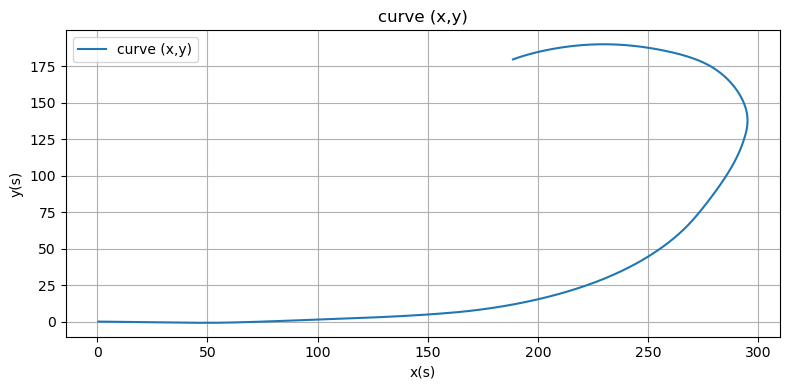

In [23]:
### DEFINE PARAM ###
T = 100     # predictive time
N = 200     # time steps
nx = 4     # dimension of state
nu = 1     # dimension of control
h = T/N    # time step size

# define the state and control constraint
kappa_min=-1
kappa_max=1
r_min=-5
r_max=5

# define all variables, X: states, U: control
X = ca.MX.sym("X", N * nx)
U = ca.MX.sym("U", (N - 1) * nu)

# x_list[i] = (s_i,r_i,phi_i,phi_{ref,i})
# u_list[i] = (Kappa_i)
x_list = [X[i*nx:(i+1)*nx] for i in range(N)]
u_list = [U[i*nu:(i+1)*nu] for i in range(N - 1)]

# define objective funtion
a1 = 6.5e-4
a2 = 1

obj = -a1*x_list[N-1][0]+a2*(h*sum(u[0]**2 for u in u_list)-h*(u_list[0][0]**2+u_list[N-2][0]**2)/2)

### LOOP for MPC ###
#define initial condition
initial_condition=[0,0,0,0]
#define variables for storing the result
x_vals=[]
y_vals=[]
r_vals=[]
s_vals=[]
for j in range (1000):
    # define constraint list
    g_list = []

    # equality constraint
    for i in range(N - 1):
        xi = x_list[i]
        ui = u_list[i]
        x_dot = ca.vertcat(
            ca.cos(xi[2]-xi[3])/(1-xi[1]*kappa_ref(xi[0])),
            ca.sin(xi[2]-xi[3]),
            ui[0],
            kappa_ref(xi[0])*ca.cos(xi[2]-xi[3])/(1-xi[1]*kappa_ref(xi[0]))
        )
        xi_next_pred = xi + h * x_dot
        g_list.append(x_list[i + 1] - xi_next_pred)

    # initial condition
    g_list.append(x_list[0] - initial_condition)

    # inequality constraint
    for u in u_list:
        g_list.append(u[0] - kappa_max)     # u <= u_max => u - u_max <= 0
        g_list.append(-u[0] + kappa_min)    # -u <= -u_min => -u + u_min <= 0
    for x in x_list:
        g_list.append(x[1] - r_max)
        g_list.append(-x[1] + r_min)

    # concat all constraints
    g = ca.vertcat(*g_list)

    # concat all variables
    Z = ca.vertcat(X, U)

    # define the NLP problem
    nlp = {'x': Z, 'f': obj, 'g': g}

    # define the solver
    solver = ca.nlpsol('solver', 'ipopt', nlp)

    # initial guess
    z0 = np.zeros(Z.shape[0])

    # upper & lower bounds for constraints
    n_eq = 4*N -4 + 4     # dynamical equation + initial condition
    n_ineq = 2 * (N - 1) +2*N # upper and lower bounds for inequality constraint

    lbg = [0] * n_eq + [-ca.inf] * n_ineq
    ubg = [0] * n_eq + [0] * n_ineq

    # solving
    sol = solver(x0=z0, lbg=lbg, ubg=ubg)
    z_opt = sol['x'].full().flatten()

    # unpack variables
    x_opt = z_opt[:nx*N].reshape((N, nx))
    u_opt = z_opt[nx*N:].reshape((N - 1, nu))

    print("if success:", solver.stats()['success'])
    print("the first 5 states:", x_opt[:5])
    print("the first 5 control:", u_opt[:5])

    # extract variables
    s_val = x_opt[1,0]  # the second value of s
    r_val = x_opt[1,1]  # the second value of r
    phi_val = x_opt[1,2] # the second value of phi
    phi_ref_val = x_opt[1,3] # the second value of phi_ref
    
    
    # coordinate transform
    x_val=x_ref(s_val).full().flatten()-r_val*np.sin(phi_ref_val)
    y_val=y_ref(s_val).full().flatten()+r_val*np.cos(phi_ref_val)
    # store them in a array
    s_vals.append(s_val)
    r_vals.append(r_val)
    x_vals.append(x_val)
    y_vals.append(y_val)
    
    # redefine initial condition
    initial_condition=[s_val,r_val,phi_val,phi_ref_val]
    print(initial_condition)

### Plot the track and resulting reference path

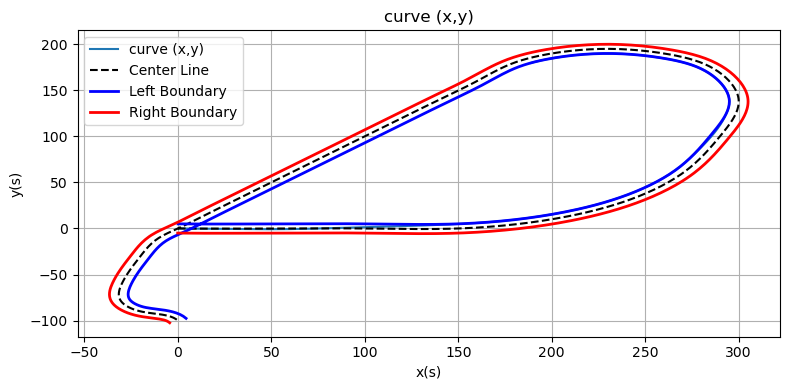

In [24]:
plt.figure(figsize=(8, 4))
plt.plot(x_vals, y_vals, label='curve (x,y)')
plt.plot(x_interp, y_interp, 'k--', linewidth=1.5, label='Center Line')
plt.plot(x_left, y_left, 'b-', linewidth=2, label='Left Boundary')
plt.plot(x_right, y_right, 'r-', linewidth=2, label='Right Boundary')
plt.xlabel('x(s)')
plt.ylabel('y(s)')
plt.title('curve (x,y)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()